In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2-4*x+5

In [ ]:
f(3.0)

20.0

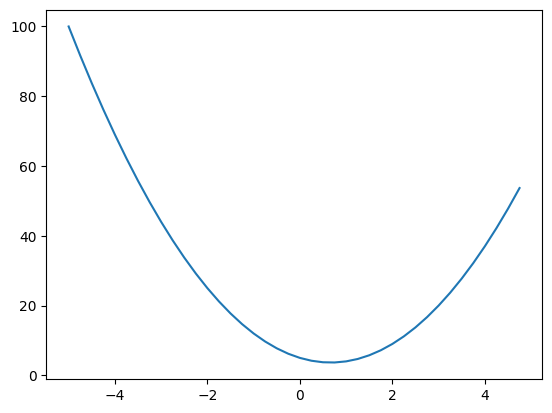

In [ ]:
xs= np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [ ]:
h=0.000000001
x=2/3
(f(x+h)-f(x))/h

0.0

In [ ]:
# Let's get more complex
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [ ]:
h=0.0001

#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b+c
a+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [ ]:
h=0.0001

#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b+c
b+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)



d1 4.0
d2 4.0002
slope 2.0000000000042206


In [ ]:
h=0.0001

#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b+c
c+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)



d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data
    self.grad=0.0
    self._backward=lambda: None
    self._prev=set(_children)
    self._op = _op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other,Value) else Value(other)  #So that operations like a+2 don't return error. here a is a 'Value'
    out=Value(self.data+other.data,(self,other),'+')

    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward=_backward

    return out

  def __sub__(self, other): # self - other
    return self + (-other)


  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)  # same as add one
    out=Value(self.data*other.data,(self,other),'*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad+=self.data*out.grad
    out._backward=_backward
    return out


  def __rmul__(self,other): # to implement other*self
    return self*other


  def __neg__(self):
    return self*-1


  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only supporting int/float powers now"
    out=Value(self.data**other,(self,),f'**{other}')

    def _backward():
      self.grad+=other*(self.data**(other-1))*out.grad
    out._backward=_backward

    return out

  def __truediv__(self,other):
    return self*other**-1



  def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t,(self,),'tanh')

    def _backward():
      self.grad+=(1-t**2)*out.grad
    out._backward=_backward

    return out

  def exp(self):
    x=self.data
    out=Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad+=out.data*out.grad
    out._backward=_backward

    return out

  def __radd__(self, other): # other + self
    return self + other


  def backward(self):
  #Topological sorting will ensure that we calculate gradient in the correct order
    topo=[]
    visited=set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad=1.0
    for node in reversed(topo):   ## Now saved in Value() only
      node._backward()


In [ ]:
from graphviz import Digraph

def trace(root):
  #builds the set of all nodes and edges in a graph
  nodes,edges=set(),set()
  def build(v):
    nodes.add(v)
    for child in v._prev:
      edges.add((child,v))
      build(child)
  build(root)
  return nodes,edges


def draw_dot(root):
  dot=Digraph(format='svg', graph_attr={'rankdir':'LR'})  ## LR stands for left to right

  nodes,edges=trace(root)
  for n in nodes:
    uid=str(id(n))
    #for any value in the graph, create a rectangular {'record'} node for it
    dot.node(name=uid, label="{%s | data%.4f| grad %.4f}"%(n.label,n.data,n.grad,), shape='record')
    if n._op:
      # if this value results is a result of some operation, create an op node for it
      dot.node(name=uid+n._op,label=n._op)
      # and connect this node to it
      dot.edge(uid+n._op,uid)
  for n1,n2 in edges:
    # connect n1 to op node of n2
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot

In [ ]:
def lol():  #perturb the value wrt which you want the derivative
  h=0.0001

  a=Value(2.0,label='a')
  b=Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L=d*f; L.label="L"
  L1=L.data

  a=Value(2.0,label='a')
  b=Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L=d*f; L.label="L"
  L2=L.data+h

  print((L2-L1)/h)

In [ ]:
#input
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

#bias
b=Value(6.8813735870195432,label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'

n=x1w1x2w2+b; n.label='n'
o=n.tanh();o.label='o'
o.backward()

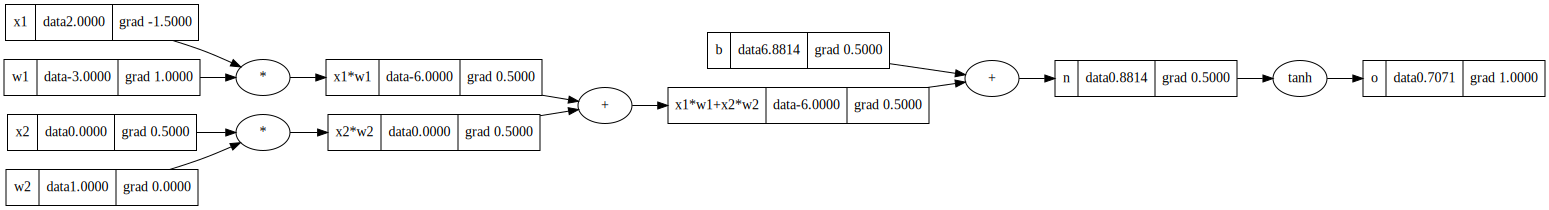

In [ ]:
draw_dot(o)

In [ ]:
#Different implementation for tanh
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

#bias
b=Value(6.8813735870195432,label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'

n=x1w1x2w2+b; n.label='n'

e=(2*n).exp()
o=(e-1)/(e+1); o.label='o'
o.backward()

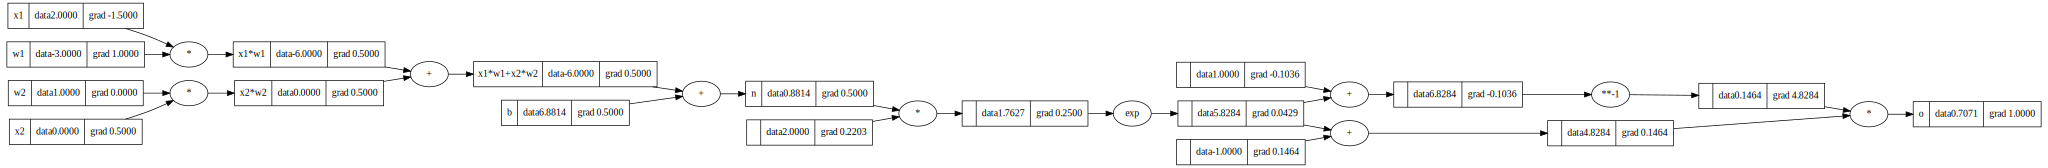

In [ ]:
draw_dot(o)

## Creating the same code using torch

In [ ]:
import torch


In [ ]:
x1=torch.Tensor([2.0]).double();                  x1.requires_grad=True
x2=torch.Tensor([0.0]).double();                  x2.requires_grad=True
w1=torch.Tensor([-3.0]).double();                 w1.requires_grad=True
w2=torch.Tensor([1.0]).double();                  w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double();     b.requires_grad=True

n=x1*w1+x2*w2+b
o=torch.tanh(n)

print(o.data.item())   #o.data.item==o.item
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random
class Neuron:

  def __init__(self,nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))

  def __call__(self,x):
    # w*x+b
    act=sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
    out=act.tanh()
    return out

  def parameters(self):
    return self.w+[self.b]

class Layer:

  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params=[]
    # for neuron in self.neurons:
    #   ps=neuron.parameters()
    #   params.extend(ps)
    # return params
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
      for layer in self.layers:
        x=layer(x)
      return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters() ]
x=[2.0,3.0,-1.0]
# n=MLP(3,[4,4,1])
n=MLP(3,[4,4,1])
n(x)




Value(data=-0.7094452812895314)

In [ ]:
# draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred=[n(x) for x in xs]   #FWD PASS
ypred

[Value(data=-0.7094452812895314),
 Value(data=-0.6904955029049601),
 Value(data=-0.6852175420201625),
 Value(data=-0.7073224687885971)]

In [ ]:
loss=sum([(yout - ygt)**2 for ygt,yout in zip(ys,ypred)])

In [ ]:
loss  #LOSS

Value(data=6.032034211727316)

In [ ]:
loss.backward()  #BACKWARD PASS
loss

Value(data=6.032034211727316)

In [ ]:
n.layers[0].neurons[0].w[0].data

0.07550269191849357

In [ ]:
# draw_dot(loss)

In [ ]:
#Gradients on input data are not useful as it would remain constant

In [ ]:
# n.parameters()

In [ ]:
n.layers[0].neurons[0].w[0].grad

-0.010745951266132259

In [ ]:
for p in n.parameters():
  p.data+=-0.005*p.grad     #FULLGD

In [ ]:
n.layers[0].neurons[0].w[0].data

0.07555642167482424

In [ ]:
ypred=[n(x) for x in xs]  ##FWD
loss=sum([(yout - ygt)**2 for ygt,yout in zip(ys,ypred)])  #LOss
loss

Value(data=5.765680960298591)

In [ ]:
for k in range(20):

  # forward pass
  ypred=[n(x) for x in xs]
  loss=sum([(yout - ygt)**2 for ygt,yout in zip(ys,ypred)])

  #backward pass
  for p in n.parameters():
    p.grad=0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data+=-0.05*p.grad
  print(k,loss.data)

0 0.007542935248360458
1 0.007442233336323406
2 0.007344128218635157
3 0.007248521611837989
4 0.007155320105234366
5 0.007064434863629558
6 0.006975781351518559
7 0.006889279076938014
8 0.006804851353368979
9 0.006722425078227137
10 0.006641930526609719
11 0.006563301159089705
12 0.006486473442455598
13 0.006411386682392817
14 0.006337982867190159
15 0.006266206521635186
16 0.006196004570332527
17 0.006127326209745702
18 0.006060122788320442
19 0.005994347694101331
